In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt


from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,10)



In [2]:
########################################
# Constants and options
kgC_to_umolsCO2_factor =  (1e3/12.0107)*1e6  #(grams of substance/molar mass) * micromoles conversion
seconds_in_year = 60.*60.*24.*365.
Lc_H2O = 2.501e6


In [9]:
# Directories and Filenames
BASE_DIR='/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/'


site='AliceHolt'
year_str='2005'
#site='AuchencorthMoss'
#year_str='2015'

ipft=0

runids=['Jv4.6_','Jv4.6_AH_']#,'Jv4.6_pdmDefault_']#'Jv4.6_traitphys_']#,'Jv4.6_MEGANemis_','Jv4.6_EMEPemis_',] 
rosetags=['','','']#,'_Rose']
#,'Jv4.6_AliceHolt_Rose','Jv4.6_tefld_AliceHolt_Rose']'Jv4.6_tefld_','Jv4.6_MEGANemis_','Jv4.6_','Jv4.6_tefld_EMEPemis_',
runids=[runid+site+rose for runid,rose in zip(runids,rosetags)]
tstep='tstep'
nJULES=len(runids)
JULES_OUTPUT_DIR=BASE_DIR+'jules_runs/output/'+site+'/'
JULES_fnames=[JULES_OUTPUT_DIR+runid+'.'+tstep+'.nc' for runid in runids]
#print(JULES_fnames)

SITE_DIR=BASE_DIR+'data/'
SITE_fname=SITE_DIR+'Isoprene_Flux_'+site+'_'+year_str+'.nc'

SITE_GPP_file=SITE_DIR+'FLUX_DATA_022017/UKHam_2005_JULES_drivefluxdata.nc.2'



In [4]:
# Read Site Data
Svars=['isoprene','isoprene_err']
print(SITE_fname)
Sinf=nc.Dataset(SITE_fname,'r')
S_Dict={}
for var in Svars:
    S_Dict[var]=Sinf.variables[var][:].squeeze()

roundtime= np.round(Sinf.variables['time'][:].astype('float64')/1800.)*1800.
S_time=nc.num2date(roundtime,Sinf.variables['time'].units)
del roundtime
Sinf.close()
S_panda1=pd.DataFrame(S_Dict,index=S_time)

Svars=['gpp','co2_flux','ter']
Sinf=nc.Dataset(SITE_GPP_file,'r')
S_Dict={}
for var in Svars:
    S_Dict[var]=Sinf.variables[var][:].squeeze()

roundtime= np.round(Sinf.variables['time'][:].astype('float64')/1800.)*1800.
S_time=nc.num2date(roundtime,Sinf.variables['time'].units)
del roundtime
Sinf.close()
S_panda2=pd.DataFrame(S_Dict,index=S_time)

S_panda=pd.concat([S_panda1,S_panda2],axis=1)


/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/data/Isoprene_Flux_AliceHolt_2005.nc


In [10]:
# Read in JULES data and convert to pandas
Jvars=['isoprene_gb','terpene_gb','lai','tstar_gb','gpp_gb','npp_gb',\
       'fsmc_gb','sw_down','precip','co2_mmr','lw_down',\
       'ftl_gb','fqw_gb','esoil_gb','ecan_gb','runoff']#,'tl1','gpp_gb']
J_pandas=[]

for Jcnt in range(nJULES):
    print(JULES_fnames[Jcnt])
    Jinf=nc.Dataset(JULES_fnames[Jcnt],'r')
    
    J_Dict={}
    for var in Jvars:
        J_Dict[var]=Jinf.variables[var][:].squeeze()
        if len(J_Dict[var].shape)>1:
            J_Dict[var]=J_Dict[var][:,ipft]
    for i in range(4):
        J_Dict['sthu_'+str(i)]=Jinf.variables['sthu'][:,i,:].squeeze()
        
    roundtime= np.round(Jinf.variables['time'][:].astype('float64')/1800.)*1800.
    J_time=nc.num2date(roundtime, Jinf.variables['time'].units)
    del roundtime
    Jinf.close()
    
    J_pandas.append( pd.DataFrame(J_Dict,index=J_time) )

/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/jules_runs/output/AliceHolt/Jv4.6_AliceHolt.tstep.nc
/prj/wetlands_africa/jules/JASMIN/BVOCs/SITE_DATA/jules_runs/output/AliceHolt/Jv4.6_AH_AliceHolt.tstep.nc


In [11]:
for panda in J_pandas:
    panda['gpp_noSMstress']=panda['gpp_gb']/panda['fsmc_gb']

In [12]:
ISO_panda=pd.concat( [panda['isoprene_gb'] for panda in J_pandas],axis=1)  #S_panda['isoprene']] +
ISO_panda.columns=runids   # ['Site']+

TERP_panda=pd.concat( [panda['terpene_gb']*3.6e12 for panda in J_pandas],axis=1)
TERP_panda.columns=runids

LAI_panda=pd.concat( [panda['lai'] for panda in J_pandas],axis=1)
LAI_panda.columns=runids

TSTAR_panda=pd.concat( [panda['tstar_gb'] for panda in J_pandas],axis=1)
TSTAR_panda.columns=runids

GPP_panda=pd.concat( [panda['gpp_gb'] for panda in J_pandas],axis=1)  #+[S_panda['gpp']] 
GPP_panda.columns=runids  ##+['Site']

GPP_noSTR_panda=pd.concat( [panda['gpp_noSMstress'] for panda in J_pandas],axis=1)  #+[S_panda['gpp']] 
GPP_noSTR_panda.columns=runids  ##+['Site']


Jv4.6_AliceHolt       1.523515
Jv4.6_AH_AliceHolt    1.567756
dtype: float64
co2_flux   -0.564268
gpp         1.585562
ter         1.080828
dtype: float64


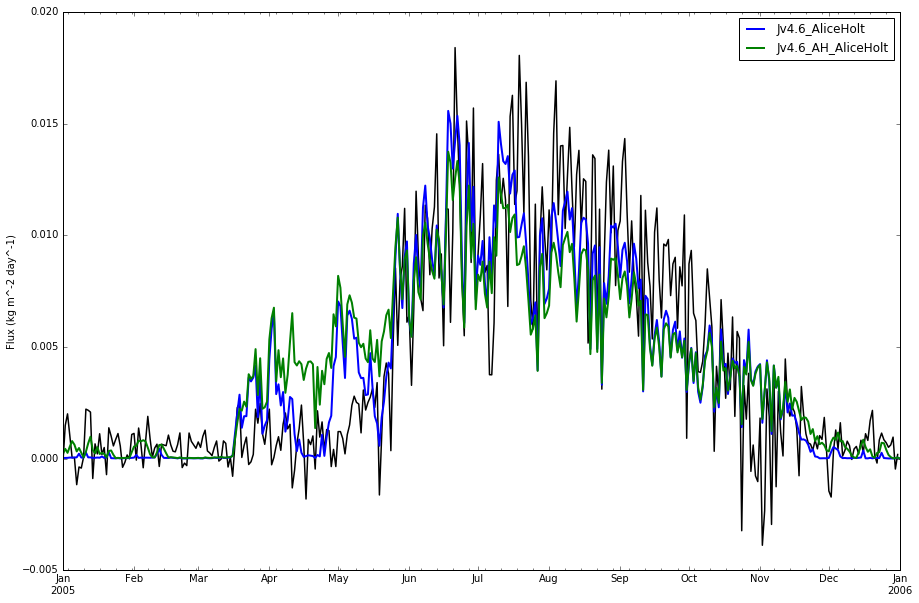

In [13]:
ax=plt.subplot(1,1,1)
(S_panda2['gpp']*12.*(1800.)*(1e-9)).resample('D').sum().plot(c='k',lw=1.5,grid=True,ax=ax)
#(J_pandas[0]['gpp_noSMstress']*(365*86400)).plot(ax=ax)
#(GPP_noSTR_panda*(1800.)).resample('D').sum().plot(ax=ax,lw=2)
(GPP_panda*3600.).resample('D').sum().plot(ax=ax,lw=2)
plt.ylabel('Flux (kg m^-2 day^-1)')
#plt.xlim(['2005-06-25','2005-09-01'])
print((GPP_panda*(365*86400)).mean())
print((S_panda2*12.*(365*86400)*1e-9).mean())

#ax2=ax.twinx()
#LAI_panda.plot(ax=ax2,c='g')
#J_pandas[0]['fsmc_gb'].plot(ax=ax2,c='k')
#(J_pandas[0]['tstar_gb']-273.15).resample('D').plot(ax=ax2,c='orange',lw=2)


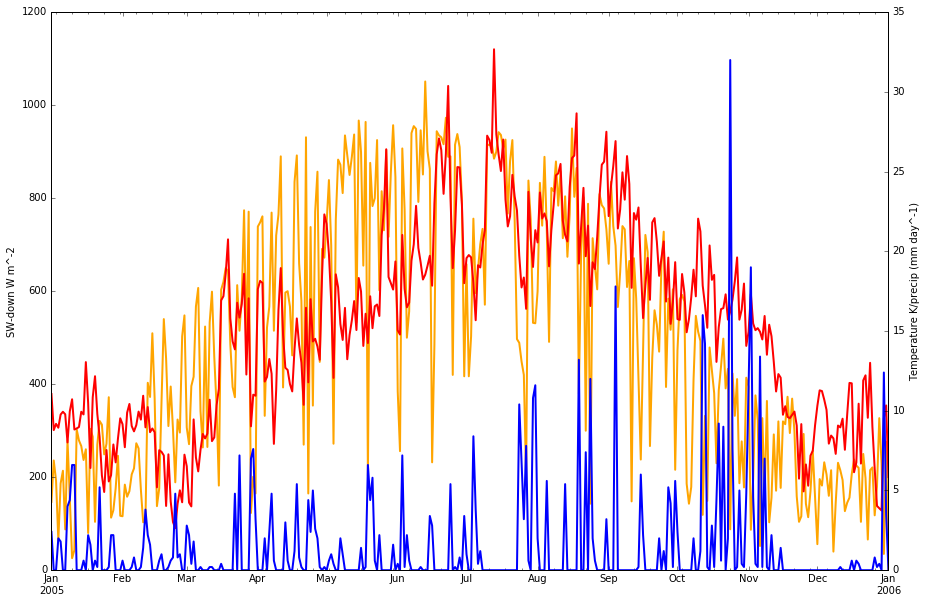

In [129]:
ax=plt.subplot(1,1,1)
ax2=ax.twinx()

J_pandas[0]['sw_down'].resample('D').max().plot(ax=ax,c='orange',lw=2)
ax.set_ylabel('SW-down W m^-2')
(J_pandas[0]['tstar_gb']-273.15).resample('D').max().plot(ax=ax2,c='red',lw=2)
ax2.set_ylabel('Temperature K/precip (mm day^-1)')
(J_pandas[0]['precip']*1800.0).resample('D').sum().plot(ax=ax2,c='blue',lw=2)


/users/eow/edwcom/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


                precip     fqw_gb     runoff
2005-01-31   42.799999 -83.249077  21.762747
2005-02-28   20.600000 -10.208258  31.472223
2005-03-31   38.000000  21.154385  28.194004
2005-04-30   37.799999  42.967682  15.963639
2005-05-31   27.799999  84.974075   8.122389
2005-06-30   26.799999  98.236778   1.984971
2005-07-31   66.000000  91.699371   0.370617
2005-08-31   51.400002  89.288376   0.090941
2005-09-30   44.599998  48.179100   2.527592
2005-10-31  114.400002  17.659164   0.919707
2005-11-30   60.000000  22.157595   0.970351
2005-12-31   19.100000  11.724556   1.887498
2006-01-31    0.000000  -0.000189   0.001350
precip    549.299927
fqw_gb    434.583557
runoff    114.268028
dtype: float32


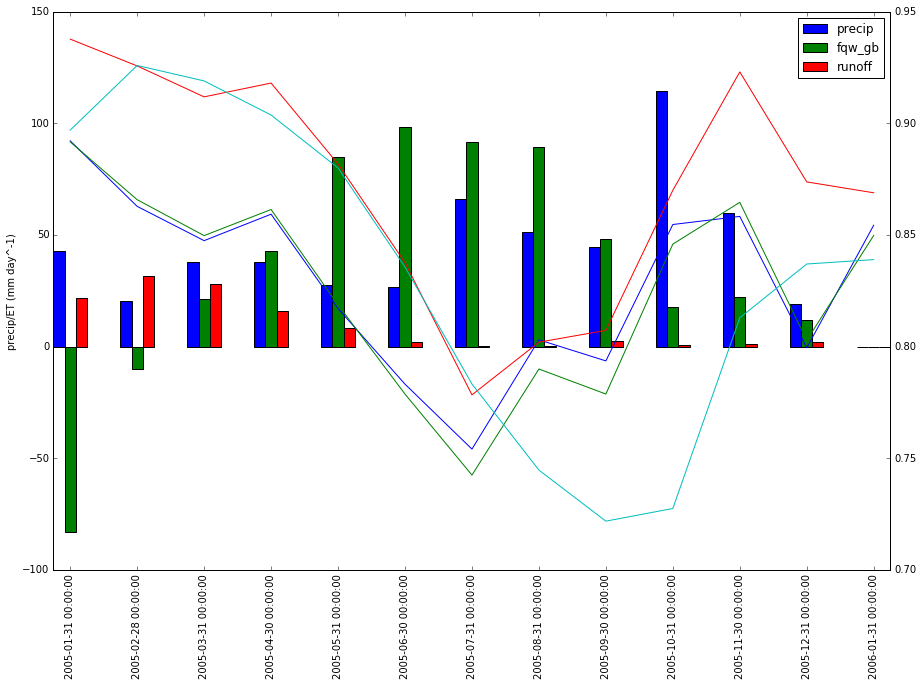

In [130]:
ax=plt.subplot(1,1,1)

PANDA=(J_pandas[0][ ['precip','fqw_gb','runoff'] ]*1800.).resample('M').sum()
PANDA.plot(ax=ax,kind='bar')
#(J_pandas[0]['precip']*1800.).resample('M').sum().plot(ax=ax,kind='bar',label='precip') #,c='blue',lw=2
#(J_pandas[0]['fqw_gb']*1800.).resample('M').sum().plot(ax=ax,kind='bar',label='fqw',color='r')
ax.set_ylabel('precip/ET (mm day^-1)')


ax2=ax.twinx()
ax2.plot(J_pandas[0][ ['sthu_0','sthu_1','sthu_2','sthu_3']   ].resample('M').mean().values)
ax2.legend()

print(PANDA)
print(PANDA.sum())

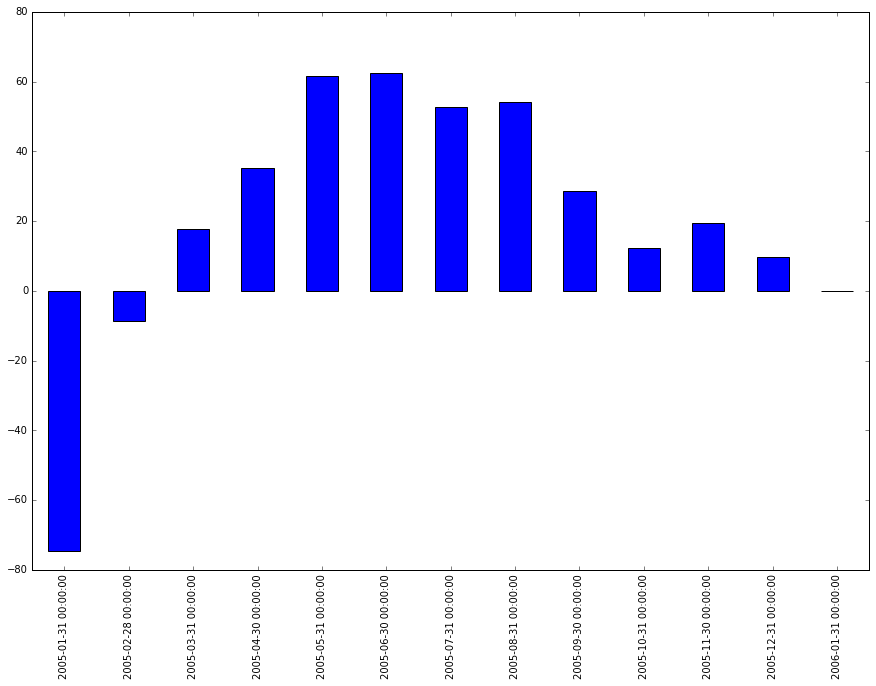

In [85]:
(J_pandas[0]['fqw_gb']*1800.).resample('M').sum().plot(kind='bar')

/users/eow/edwcom/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()


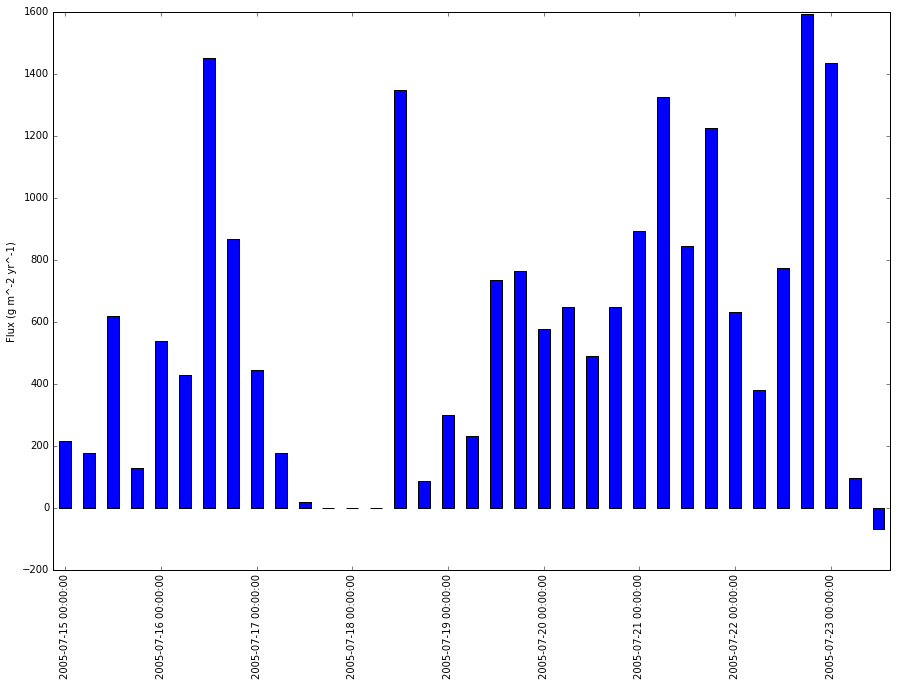

In [133]:
ax=plt.subplot(1,1,1)
#(S_panda1['isoprene']*(365*24)*(1e-6)).plot(c='r',lw=2,grid=True,ax=ax)
S_panda1['isoprene'].dropna().resample('D').plot(kind='bar')
#(ISO_panda*3.6e6*(365*24)).plot(ax=ax)
plt.ylabel('Flux (g m^-2 yr^-1)')
#plt.xlim(['2005-06-25','2005-09-01'])
#print(['2005-%02d-01' %(mnt) for mnt in range(1,13)])
#plt.xticks(['2005-06-01','2005-06-01']) 
plt.locator_params(nbins=10)


In [ ]:
#TERP_panda.plot()
(LAI_panda[180*48:240*48]).plot(lw=2.5)
plt.ylabel('LAI (m^2 m^-2')
plt.ylim([0,4])

In [ ]:
#TERP_panda.plot()
(TSTAR_panda[180*48:240*48]).plot(lw=2.5)
plt.ylabel('Tstar (K)')


In [ ]:

(TERP_panda[180*48:240*48]).plot(lw=2.5)
plt.ylabel('Flux (ug m^-2 h^-1')